В днном кейсе необходимо было провести анализ результатов A/B-тестирования. Для этого нужно:
1.	Проанализировать есть ли пользователи, которые попали в обе группы тестирования. Если да, то исключить их.
2.	Проанализировать выбросы в данных с помощью диаграммы размаха («ящика с усами»). Поработать с ними, чтобы исключить вероятность их влияния на результаты тестирования. 
3.	Исключить дубли в записях для одного и того же пользователя. 
4.	Использовать разные статистики для сравнения групп платящих и не платящих пользователей. 
5.	Проверить распределение на нормальность, используя разные статистические тесты (Шапиро-Уилка, Манна-Уитни, бутстраппинг и т.д.)
6.	Сделать выводы по результатам A/B-тестирования.

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

abrez = pd.read_csv("AB_Test_Results.csv")

In [2]:
abrez

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


In [3]:
dubl = abrez.groupby(('USER_ID'), as_index=False).agg({'VARIANT_NAME': 'nunique'})
dubl = dubl[dubl['VARIANT_NAME'] == 1]

In [4]:
ochi = abrez.merge(dubl, on='USER_ID', how='inner')
ochi.rename(columns={'VARIANT_NAME_x':'VARIANT_NAME'}, inplace=True)
ochi.drop(columns=['VARIANT_NAME_y'], inplace=True)
ochi

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,737,variant,0.0
2,6174,variant,0.0
3,2380,variant,0.0
4,9168,control,0.0
...,...,...,...
6065,428,control,0.0
6066,8864,variant,0.0
6067,502,variant,0.0
6068,7741,control,0.0


In [5]:
newochi = ochi[ochi['REVENUE'] > 0]
newochi

,USER_ID,VARIANT_NAME,REVENUE
17,8927,variant,0.06
46,6429,control,3.25
114,6207,control,0.04
142,3331,variant,4.27
150,8110,variant,1.75
...,...,...,...
5793,2138,control,0.58
5820,8076,control,1.66
5868,6623,control,1.78
5960,6468,control,2.93


<AxesSubplot:ylabel='REVENUE'>

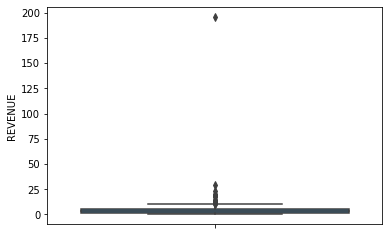

In [6]:
sns.boxplot(y='REVENUE', data=newochi)

In [7]:
Q1 = newochi['REVENUE'].quantile(0.25)
Q3 = newochi['REVENUE'].quantile(0.75)
IQR = (newochi['REVENUE'].quantile(0.75) - newochi['REVENUE'].quantile(0.25))

In [8]:
newochi = newochi[~(newochi['REVENUE'] > Q3+1.5*IQR) | (newochi['REVENUE'] < Q1-1.5*IQR)]
newochi.drop_duplicates(subset='USER_ID', inplace=True)
newochi

C:\Users\rozan\Anaconda\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,USER_ID,VARIANT_NAME,REVENUE
17,8927,variant,0.06
46,6429,control,3.25
114,6207,control,0.04
142,3331,variant,4.27
150,8110,variant,1.75
...,...,...,...
5793,2138,control,0.58
5820,8076,control,1.66
5868,6623,control,1.78
5960,6468,control,2.93


In [9]:
plat = newochi[newochi['VARIANT_NAME'] == 'control']
neplat = newochi[newochi['VARIANT_NAME'] == 'variant']

In [10]:
stats.ttest_ind(a=newochi['VARIANT_NAME'] == 'control', b=newochi['VARIANT_NAME'] == 'variant')
# гипотеза не отвергается, средний вес между платящими и не платящими пользователями равен

Ttest_indResult(statistic=1.2477005877840874, pvalue=0.21394125653814053)

In [11]:
from scipy.stats import f_oneway

f_statistic, p_value = f_oneway(newochi['VARIANT_NAME'] == 'control', newochi['VARIANT_NAME'] == 'variant')
print("F-статистика:", f_statistic)
print("p-значение:", p_value)
#  дисперсия между платящими и не платящими пользователями равна

F-статистика: 1.556756756756757
p-значение: 0.2139412565381412


In [13]:
import scipy.stats as stats

stats.mannwhitneyu(newochi['VARIANT_NAME'] == 'control', newochi['VARIANT_NAME'] == 'variant', alternative='two-sided')
# гипотеза о том, что медианные значения не отвергается

MannwhitneyuResult(statistic=3690.0, pvalue=0.21361868073930546)

In [12]:
from scipy.stats import shapiro

statistic, p_value = shapiro(newochi['REVENUE'])
print('Test statistic:', statistic)
print('p-value:', p_value)
# у нас есть основание отклонить гипотезу о нормальном распределении данных

Test statistic: 0.8911919593811035
p-value: 4.1702473936311435e-06


In [15]:
from scipy.stats import kstest

kstest(newochi['REVENUE'], 'norm')
# нулевая гипотеза отвергается, данные выборки не подчинены нормальному распределению

KstestResult(statistic=0.6828081607026892, pvalue=1.7266011065703023e-38)